In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
# Create GIF
def create_gif(image_list, gif_name, ds):
    frames = []
    for image_name in image_list:
        if image_name.endswith('.png'):
            print(image_name)
            frames.append(imageio.imread(image_name))
    # Save them as frames into a gif
    imageio.mimsave(gif_name, frames, 'GIF', duration = ds)
    return

In [ ]:
# This code aims do debug the three ratio, consider the effect of electrolyte being squeezed out

In [2]:
# Define a function to calculate concentration change, whether electrolyte being squeezed out or added in
def Cal_new_con_Update(Sol,Para):   # subscript r means the reservoir
    # Note: c_EC_r is the initial EC  concentraiton in the reservoir; 
    #       c_e_r  is the initial Li+ concentraiton in the reservoir;
    #############################################################################################################################  
    ###############################           Step-1 Prepare parameters:        #################################################
    #############################################################################################################################  
    L_p   =Para["Positive electrode thickness [m]"]
    L_n   =Para["Negative electrode thickness [m]"]
    L_s   =Para["Separator thickness [m]"]
    L_y   =Para["Electrode width [m]"]   # Also update to change A_cc and therefore Q
    L_z   =Para["Electrode height [m]"]
    c_EC_r_old=Para["Current solvent concentration in the reservoir [mol.m-3]"]   # add two new parameters for paper 2
    c_e_r_old =Para["Current electrolyte concentration in the reservoir [mol.m-3]"]
    # Initial EC concentration in JR
    c_EC_JR_old =Para["Bulk solvent concentration [mol.m-3]"]  # Be careful when multiplying with pore volume to get amount in mole. Because of electrolyte dry out, that will give more amount than real.   
    # LLI due to electrode,Ratio of EC and lithium is 1:1 -> EC amount consumed is LLINegSEI[-1]
    LLINegSEI = Sol["Loss of lithium to negative electrode SEI [mol]"].entries[-1] - Sol["Loss of lithium to negative electrode SEI [mol]"].entries[0]
    LLINegDeadLiP = Sol["Loss of lithium to negative electrode dead lithium plating [mol]"].entries[-1] - Sol["Loss of lithium to negative electrode dead lithium plating [mol]"].entries[0]
    LLINegLiP = Sol["Loss of lithium to negative electrode lithium plating [mol]"].entries[-1] - Sol["Loss of lithium to negative electrode lithium plating [mol]"].entries[0]
    cLi_Xavg  = Sol["X-averaged electrolyte concentration [mol.m-3]"].entries[-1] 
    # Pore volume change with time:
    PoreVolNeg_0 = Sol["X-averaged negative electrode porosity"].entries[0]*L_n*L_y*L_z;
    PoreVolSep_0 = Sol["X-averaged separator porosity"].entries[0]*L_s*L_y*L_z;
    PoreVolPos_0 = Sol["X-averaged positive electrode porosity"].entries[0]*L_p*L_y*L_z;
    PoreVolNeg_1 = Sol["X-averaged negative electrode porosity"].entries[-1]*L_n*L_y*L_z;
    PoreVolSep_1 = Sol["X-averaged separator porosity"].entries[-1]*L_s*L_y*L_z;
    PoreVolPos_1 = Sol["X-averaged positive electrode porosity"].entries[-1]*L_p*L_y*L_z;
    #############################################################################################################################  
    ##### Step-2 Determine How much electrolyte is added (from the reservoir to JR) or squeezed out (from JR to reservoir) ######
    #######################   and finish electrolyte mixing     #################################################################  
    Vol_Elely_Tot_old = Para["Current total electrolyte volume in whole cell [m3]"] 
    Vol_Elely_JR_old  = Para["Current total electrolyte volume in jelly roll [m3]"] 
    if Vol_Elely_Tot_old - Vol_Elely_JR_old < 0:
        print('Model error! Electrolyte in JR is larger than in the cell!')
    Vol_Pore_tot_old  = PoreVolNeg_0 + PoreVolSep_0 + PoreVolPos_0    # pore volume at start time of the run
    Vol_Pore_tot_new  = PoreVolNeg_1 + PoreVolSep_1 + PoreVolPos_1    # pore volume at end   time of the run, intrinsic variable 
    Vol_Pore_decrease = Vol_Elely_JR_old  - Vol_Pore_tot_new;
    # EC:lithium:SEI=2:2:1     for SEI=(CH2OCO2Li)2
    # Because inner and outer SEI partial molar volume is the same, just set one for whole SEI
    VmolSEI   = Para["Outer SEI partial molar volume [m3.mol-1]"] # 9.8e-5,
    VmolLiP   = Para["Lithium metal partial molar volume [m3.mol-1]"] # 1.3e-05
    VmolEC    = 6.667e-5  # Unit:m3.mol-1; According to Wiki, correct value: EC molar volume is :66.67 cm3.mol-1  = 6.667e-5, 
    Vol_EC_consumed  =  ( LLINegSEI + LLINegDeadLiP  ) * VmolEC    # Mark: Ruihe add LLINegDeadLiP, either with 2 or not, will decide how fast electrolyte being consumed!
    Vol_Elely_need   = Vol_EC_consumed - Vol_Pore_decrease
    Vol_SEILiP_increase = 0.5*(LLINegSEI * VmolSEI + LLINegLiP * VmolLiP)    #  volume increase due to SEI+total LiP 
    Test_V = Vol_SEILiP_increase - Vol_Pore_decrease  #  This value should always be zero, but now not, which becomes the source of error!
    Test_V2= (Vol_Pore_tot_old - Vol_Elely_JR_old) / Vol_Elely_JR_old * 100; # Porosity errors due to first time step
    
    # Start from here, there are serveral variables to be determined:
    #   1) Vol_Elely_add, or Vol_Elely_squeezed; depends on conditions. easier for 'squeezed' condition
    #   2) Vol_Elely_Tot_new, should always equals to Vol_Elely_Tot_old -  Vol_EC_consumed;
    #   3) Vol_Elely_JR_new, for 'add' condition: see old code; for 'squeezed' condition, equals to pore volume in JR
    #   4) Ratio_Dryout, for 'add' condition: see old code; for 'squeezed' condition, equals to Vol_Elely_Tot_new/Vol_Pore_tot_new 
    #   5) Ratio_CeEC_JR and Ratio_CeLi_JR: for 'add' condition: see old code; for 'squeezed' condition, equals to 1 (unchanged)
    #   6) c_e_r_new and c_EC_r_new: for 'add' condition: equals to old ones (unchanged); for 'squeezed' condition, need to carefully calculate     
    #   7) Width_new: for 'add' condition: see old code; for 'squeezed' condition, equals to L_y (unchanged)
    Vol_Elely_Tot_new = Vol_Elely_Tot_old - Vol_EC_consumed;
    
    if Vol_Elely_need < 0:
        print('Electrolyte is being squeezed out, check plated lithium (reversible part)')
        Vol_Elely_squeezed = - Vol_Elely_need;   # Make Vol_Elely_squeezed>0 for simplicity 
        Vol_Elely_add = 0.0;
        Vol_Elely_JR_new = Vol_Pore_tot_new; 
        Ratio_Dryout = Vol_Elely_Tot_new / Vol_Elely_JR_new
        Ratio_CeEC_JR = 1.0;    # the concentrations in JR don't need to change
        Ratio_CeLi_JR = 1.0; 
        SqueezedLiMol   =  Vol_Elely_squeezed*cLi_Xavg;
        SqueezedECMol   =  Vol_Elely_squeezed*c_EC_JR_old;
        Vol_Elely_reservoir_old = Vol_Elely_Tot_old - Vol_Elely_JR_old; 
        LiMol_reservoir_new = Vol_Elely_reservoir_old*c_e_r_old  + SqueezedLiMol;
        ECMol_reservoir_new = Vol_Elely_reservoir_old*c_EC_r_old + SqueezedECMol;
        c_e_r_new= LiMol_reservoir_new / (Vol_Elely_reservoir_old+Vol_Elely_squeezed);
        c_EC_r_new= ECMol_reservoir_new / (Vol_Elely_reservoir_old+Vol_Elely_squeezed);
        Width_new = L_y; 
    else:   # this means Vol_Elely_need >= 0, therefore the folliwing script should works for Vol_Elely_need=0 as well!
        # Important: Calculate added electrolyte based on excessive electrolyte, can be: 1) added as required; 2) added some, but less than required; 3) added 0 
        Vol_Elely_squeezed = 0;  
        if Vol_Elely_Tot_old > Vol_Elely_JR_old:                             # This means Vol_Elely_JR_old = Vol_Pore_tot_old ()
            if Vol_Elely_Tot_old-Vol_Elely_JR_old >= Vol_Elely_need:         # 1) added as required
                Vol_Elely_add     = Vol_Elely_need;  
                Vol_Elely_JR_new  = Vol_Pore_tot_new;  # also equals to 'Vol_Pore_tot_new', or Vol_Pore_tot_old - Vol_Pore_decrease
                Ratio_Dryout = 1.0;
            else:                                                            # 2) added some, but less than required;                                                         
                Vol_Elely_add     = Vol_Elely_Tot_old - Vol_Elely_JR_old;   
                Vol_Elely_JR_new  = Vol_Elely_Tot_new;                       # This means Vol_Elely_JR_new <= Vol_Pore_tot_new
                Ratio_Dryout = Vol_Elely_JR_new/Vol_Pore_tot_new;
        else:                                                                # 3) added 0 
            Vol_Elely_add = 0;
            Vol_Elely_JR_new  = Vol_Elely_Tot_new; 
            Ratio_Dryout = Vol_Elely_JR_new/Vol_Pore_tot_new;

        # Next: start mix electrolyte based on previous defined equation
        # Lithium amount in liquid phase, at initial time point
        TotLi_Elely_JR_Old = Sol["Total lithium in electrolyte [mol]"].entries[-1]; # remember this is only in JR
        # Added lithium and EC amount in the added lithium electrolyte: - 
        AddLiMol   =  Vol_Elely_add*c_e_r_old
        AddECMol   =  Vol_Elely_add*c_EC_r_old
        # Total amount of Li and EC in current electrolyte:
        # Remember Li has two parts, initial and added; EC has three parts, initial, consumed and added
        TotLi_Elely_JR_New   = TotLi_Elely_JR_Old + AddLiMol
        TotECMol_JR   = Vol_Elely_JR_old*c_EC_JR_old - LLINegSEI + AddECMol  # EC:lithium:SEI=2:2:1     for SEI=(CH2OCO2Li)2
        Ratio_CeEC_JR  = TotECMol_JR    /   Vol_Elely_JR_new   / c_EC_JR_old
        Ratio_CeLi_JR  = TotLi_Elely_JR_New    /   TotLi_Elely_JR_Old   /  Ratio_Dryout # Mark, change on 21-11-19
        c_e_r_new  = c_e_r_old;
        c_EC_r_new = c_EC_r_old;
        Width_new   = Ratio_Dryout * L_y;
        
    # Collect the above parameter in Data_Pack to shorten the code  
    Data_Pack   = [
        Vol_EC_consumed, 
        Vol_Elely_need, 
        Test_V, 
        Test_V2, 
        Vol_Elely_add, 
        Vol_Elely_Tot_new, 
        Vol_Elely_JR_new, 
        Vol_Pore_tot_new, 
        Vol_Pore_decrease, 
        c_e_r_new, c_EC_r_new,
        Ratio_Dryout, Ratio_CeEC_JR, 
        Ratio_CeLi_JR,
        Width_new, 
        ]  # 16 in total
    #print('Loss of lithium to negative electrode SEI', LLINegSEI, 'mol') 
    #print('Loss of lithium to negative electrode dead lithium plating', LLINegDeadLiP, 'mol') 
    #############################################################################################################################  
    ###################       Step-4 Update parameters here        ##############################################################
    #############################################################################################################################
    Para.update(   {'Bulk solvent concentration [mol.m-3]':  c_EC_JR_old * Ratio_CeEC_JR  })
    Para.update(   {'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    Ratio_CeLi_JR })
    Para.update(   {'Current total electrolyte volume in whole cell [m3]':  Vol_Elely_Tot_new  })
    Para.update(   {'Current total electrolyte volume in jelly roll [m3]':  Vol_Elely_JR_new  })
    Para.update(   {'Ratio of electrolyte dry out in jelly roll':Ratio_Dryout})
    Para.update(   {'Electrode width [m]':Width_new})    
    Para.update(   {'Current solvent concentration in the reservoir [mol.m-3]':c_EC_r_new})     
    Para.update(   {'Current electrolyte concentration in the reservoir [mol.m-3]':c_e_r_new})             
    return Data_Pack,Para

In [3]:
# Define a function to update parameter and lithium concentration in solution     
""" def Update_param ( Para, Ratio_CeEC, Ratio_Dryout, Vol_Elely_Tot, Vol_Elely_JR ):
    Old_CeEC = Para["Bulk solvent concentration [mol.m-3]"]
    Old_L_y  = Para["Electrode width [m]"]
    Para.update(   {'Bulk solvent concentration [mol.m-3]':  Old_CeEC * Ratio_CeEC  })
    Para.update(   {'Current total electrolyte volume in whole cell [m3]':  Vol_Elely_Tot  })
    Para.update(   {'Current total electrolyte volume in jelly roll [m3]':  Vol_Elely_JR  })
    Para.update(   {'Ratio of electrolyte dry out in jelly roll':Ratio_Dryout})
    Para.update(   {'Electrode width [m]':Ratio_Dryout * Old_L_y})
    # Elely_Con_Dimless_old = Sol["Electrolyte concentration"].entries 
    # Sol.update(      {'Electrolyte concentration': Elely_Con_Dimless_old*Ratio_CeLi  })  # Important: update solution - turn out not work
    return Para   # call function: Para_new, Sol_new = Update_param ( Sol, Para, Ratio_CeLi, Ratio_CeEC, Ratio_Dryout )
# Para_update, Sol_update  = Update_param (  Sol_All_0[-1], Para_All[-1], Ratio_CeLi_All[-1], Ratio_CeEC_All[-1], Ratio_Dryout_All[-1]  )
 """
# Define a function to calculate based on previous solution
def Run_Model_Base_On_Last_Solution( Model  , Sol , Para_update, ModelExperiment, Update_Cycles ):
    # Use Sulzer's method: inplace = false
    ModelTimer = pb.Timer()
    # Important line: define new model based on previous solution
    Ratio_CeLi = Para_update["Ratio of Li-ion concentration change in electrolyte consider solvent consumption"]
    dict_short = {}; 
    list_short = [  "Discharge capacity [A.h]",   # mark Ruihe Li change for FullyCoupled as this is an old version of PyBaMM
        "Negative particle concentration",
        "Positive particle concentration",
        "Negative electrode potential",
        "Positive electrode potential",
        "Total negative electrode interfacial current density variable" ,
        "Total positive electrode interfacial current density variable",
        "Negative electrode porosity",
        "Separator porosity",
        "Positive electrode porosity",
        "Inner negative electrode SEI thickness",
        "Outer negative electrode SEI thickness",
        "Negative electrolyte potential",
        "Separator electrolyte potential",
        "Positive electrolyte potential",
        "Negative electrolyte concentration",
        "Separator electrolyte concentration",
        "Positive electrolyte concentration",   
        "Negative electrode lithium plating concentration",
        "Negative electrode dead lithium concentration",]
    for list_short_i in list_short:
        dict_short.update( { list_short_i : Sol.last_state[list_short_i].data  }  )
    dict_short["Negative electrolyte concentration"] = dict_short["Negative electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Separator electrolyte concentration"] = dict_short["Separator electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Positive electrolyte concentration"] = dict_short["Positive electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    ModelModel_new = Model.set_initial_conditions_from(dict_short, inplace=False)
    #Para_update.update(   {'Ambient temperature [K]':313.15 });   # run model at 45 degree C
    #Para_update.update(   {'Initial temperature [K]':313.15 });
    ModelSimnew = pb.Simulation(
        ModelModel_new,
        experiment = ModelExperiment, 
        parameter_values=Para_update, 
        solver = pb.CasadiSolver(),
    )
    Sol_new = ModelSimnew.solve(save_at_cycles = Update_Cycles) # save every several cycles, can save RAM greatly
    # print("Solved this model in {}".format(ModelTimer.time()))
    return ModelModel_new, Sol_new
def Run_Model_Base_On_Last_Solution_RPT( Model  , Sol,  Para_update, ModelExperiment ,Update_Cycles):
    # Use Sulzer's method: inplace = false
    ModelTimer = pb.Timer()
    Ratio_CeLi = Para_update["Ratio of Li-ion concentration change in electrolyte consider solvent consumption"]
    # print("Model is now using average EC Concentration of:",Para_update['Bulk solvent concentration [mol.m-3]'])
    # print("Ratio of electrolyte dry out in jelly roll is:",Para_update['Ratio of electrolyte dry out in jelly roll'])
    # print("Model is now using an electrode width of:",Para_update['Electrode width [m]'])
    # Important line: define new model based on previous solution
    dict_short = {}; 
    list_short = [  "Discharge capacity [A.h]", # mark Ruihe Li change for FullyCoupled as this is an old version of PyBaMM
        "Negative particle concentration",
        "Positive particle concentration",
        "Negative electrode potential",
        "Positive electrode potential",
        "Total negative electrode interfacial current density variable" ,
        "Total positive electrode interfacial current density variable",
        "Negative electrode porosity",
        "Separator porosity",
        "Positive electrode porosity",
        "Inner negative electrode SEI thickness",
        "Outer negative electrode SEI thickness",
        "Negative electrolyte potential",
        "Separator electrolyte potential",
        "Positive electrolyte potential",
        "Negative electrolyte concentration",
        "Separator electrolyte concentration",
        "Positive electrolyte concentration",   
        "Negative electrode lithium plating concentration",
        "Negative electrode dead lithium concentration", ]
    for list_short_i in list_short:
        dict_short.update( { list_short_i : Sol.last_state[list_short_i].data  }  )
    dict_short["Negative electrolyte concentration"] = dict_short["Negative electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Separator electrolyte concentration"]          = dict_short["Separator electrolyte concentration"] * Ratio_CeLi          # important: update sol here!
    dict_short["Positive electrolyte concentration"] = dict_short["Positive electrolyte concentration"] * Ratio_CeLi # important: update sol here!
    ModelModel_new = Model.set_initial_conditions_from(dict_short, inplace=False)
    Para_update.update(   {'Ambient temperature [K]':298.15 });
    Para_update.update(   {'Initial temperature [K]':298.15 });
    ModelSimnew = pb.Simulation(
        ModelModel_new,
        experiment = ModelExperiment, 
        parameter_values=Para_update, 
        solver = pb.CasadiSolver(),
    )
    Sol_new = ModelSimnew.solve(save_at_cycles = Update_Cycles) # save every several cycles, can save RAM greatly
    # print("Solved this model in {}".format(ModelTimer.time()))
    return ModelModel_new, Sol_new

print(Test_V)
print(Vol_Pore_tot_new)
print(Vol_Elely_JR_new)
print(Ratio_Dryout)
print(Vol_EC_consumed-Vol_Pore_decrease)


In [4]:
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    if c_e < 2000:
        D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    else:
        D_c_e = 8.794e-11 * (2000 / 1000) ** 2 - 3.972e-10 * (2000 / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    if c_e < 2000:
        sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    else:
        sigma_e = (0.1297 * (2000 / 1000) ** 3 - 2.51 * (2000 / 1000) ** 1.5 + 3.329 * (2000 / 1000))
    return sigma_e

In [5]:
# ################        Global setting  ################################# #################################
for i in range(0,1):  
    Total_Cycles = 1170; Cycle_bt_RPT = 78; Update_Cycles = 26;  Small_Loop =  int(Cycle_bt_RPT/Update_Cycles);   SaveTimes = int(Total_Cycles/Cycle_bt_RPT);   RPT_Cycles = 1; 

    # Special cases for Non-dry-out model:
    Total_Cycles_NonDry = 1170;   SaveTimes_NonDry = int(Total_Cycles_NonDry/Cycle_bt_RPT);  

    Real_SaveAs_Cycles = 1 # Set this to use it in real experiment so that can really get capacity throughput!
    V_max = 4.2;        V_min = 2.5;
    cs_Neg_Init = 28920; Diff_SEI = 1.700000000000002e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;
    Experiment_Long   = pb.Experiment(  [(f"Discharge at 1 C until {V_min} V", f"Charge at 0.3 C until {V_max} V", f"Hold at {V_max} V until C/100"),  ] * Update_Cycles  )  
    Experiment_RPT    = pb.Experiment( [ (f"Discharge at 0.1C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1C until {V_max} V" ) ] * RPT_Cycles ) 
    Experiment_Breakin= pb.Experiment( [ ( f"Discharge at 0.1C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1C until {V_max} V" )  ] *2 )
    #BasicPath = 'C:/Users/rl1120/OneDrive - Imperial College London/PhD Study/Imperial Study/Model/Pybamm Learning/SimDataSave/2nd paperTest R0/';
    #Target = 'Ruan-Test-1/';
    #if not os.path.exists(BasicPath + Target):
    #    os.mkdir(BasicPath + Target);
    ################ Important: index definition #################################
    index = list(np.arange(1,SaveTimes+1)*(Small_Loop+RPT_Cycles)-1); #index.insert(0,0)  # get all last ageing cycle before RPT, plus the first RPT test
    index2= list(np.arange(0,SaveTimes+1)*(Small_Loop+RPT_Cycles));         # get all RPT test
    cycles = np.arange(0,SaveTimes+1)*Cycle_bt_RPT; 
    cycles3 = list(np.arange(1,SaveTimes+1)*(Cycle_bt_RPT)); 

    index_NonDry    = list(np.arange(1,SaveTimes_NonDry+1)*(Small_Loop+RPT_Cycles)-1); #index.insert(0,0)  # get all last ageing cycle before RPT, plus the first RPT test
    index2_NonDry   = list(np.arange(0,SaveTimes_NonDry+1)*(Small_Loop+RPT_Cycles));         # get all RPT test  
    cycles_NonDry   = np.arange     (0,SaveTimes_NonDry+1)*Cycle_bt_RPT; 
    cycles3_NonDry  = list(np.arange(1,SaveTimes_NonDry+1)*(Cycle_bt_RPT)); 

# Get 0 SOC:
Experiment_Dis= pb.Experiment(  
    [(f"Discharge at 1 C until {V_min} V", ),  ] * 1  ) 
ChemistryChen=pb.parameter_sets.Chen2020_coupled   # Ren2018  Chen2020_plating
Para_0=pb.ParameterValues(chemistry=ChemistryChen)
Para_0.update({'SEI resistivity [Ohm.m]':R_SEI}) ;
Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI});
Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con});
Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init })
Para_0.update({'Initial electrolyte excessive amount ratio':1})   # 
Model_0 = pb.lithium_ion.DFN(     
options={
    "particle": "Fickian diffusion",          
    "SEI":"interstitial-diffusion limited",          
    "SEI film resistance":"distributed",          
    "SEI porosity change":"true",         
    "lithium plating":"partially reversible"     } ) #
ModelTimer = pb.Timer()
Sim_0    = pb.Simulation(
    Model_0,        experiment = Experiment_Dis,
    parameter_values = Para_0,
    solver = pb.CasadiSolver(),) #mode="safe"
Sol_0    = Sim_0.solve()

print('Total Electrolyte in cell',Vol_Elely_Tot_All_All)  ;       print('Total Electrolyte in JR',Vol_Elely_JR_All_All) ;         print('Total Pore in JR',Vol_Pore_tot_All_All)
print(Ratio_CeEC_All_All)     ;       print(Ratio_CeLi_All_All) ;          print(Ratio_Dryout_All_All) 
print('EC consume volume',Vol_EC_consumed_All_All);       print('Electrolyte needed',Vol_Elely_need_All_All) ;      print(Width_all_All)        ;
print('Added Electrolyte',Vol_Elely_add_All_All)  ;       print('Pore volume decrease in JR',Vol_Pore_decrease_All_All) ;  


In [6]:
# Run model with electrolyte dry out
#Diff_OutSEI = [0.5000000000000002e-22,2.5000000000000002e-22,7.5000000000000002e-22]; Diff_OutSEI_Succeed = [];
Ratio_excess = [1.0,];   
for mm in range(0,1):
    Vol_Elely_Tot_All_All  = [];       Vol_Elely_JR_All_All =[];         Vol_Pore_tot_All_All =[];
    Ratio_CeEC_All_All     = [];       Ratio_CeLi_All_All = [];          Ratio_Dryout_All_All =[];
    Vol_EC_consumed_All_All= [];       Vol_Elely_need_All_All = [];      Width_all_All        =[];
    Vol_Elely_add_All_All  = [];       Vol_Pore_decrease_All_All =[];    Index_update_all_all =[]; 
    Test_V_All_All=[];                 Test_V2_All_All=[];               c_e_r_new_All_All=[];     c_EC_r_new_All_All=[]; 
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All_All = [];  Epsilon_SEI_Neg_CCend_Dry_All_All=[];     Epsilon_CCend_Dry_All_All = [];    Epsilon_ce_CCend_Dry_All_All = [];  
    jSEI_Neg_Int_CCend_Dry_All_All = []; j_Neg_Int_CCend_Dry_All_All = [];         j_Neg_CCend_Dry_All_All = [];        # four current density
    Eta_Elely_CCend_Dry_All_All = [];  c_Li_Elely_CCend_Dry_All_All = []; Eta_Neg_rec_CCend_Dry_All_All =[];   
    c_s_Neg_Surf_CCend_Dry_All_All = [];  ElelyConduct_CCend_Dry_All_All = []; ElelyDiff_CCend_Dry_All_All = [];
    Eff_ElelyConduct_CCend_Dry_All_All = []; Eff_ElelyDiff_CCend_Dry_All_All = [];
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All_All = [];  Epsilon_SEI_Neg_CDend_Dry_All_All=[];     Epsilon_CDend_Dry_All_All = [];    Epsilon_ce_CDend_Dry_All_All = [];  
    jSEI_Neg_Int_CDend_Dry_All_All = []; j_Neg_Int_CDend_Dry_All_All = [];         j_Neg_CDend_Dry_All_All = [];        # four current density
    Eta_Elely_CDend_Dry_All_All = [];  c_Li_Elely_CDend_Dry_All_All = []; Eta_Neg_rec_CDend_Dry_All_All =[];   
    c_s_Neg_Surf_CDend_Dry_All_All = [];  ElelyConduct_CDend_Dry_All_All = []; ElelyDiff_CDend_Dry_All_All = [];
    Eff_ElelyConduct_CDend_Dry_All_All = []; Eff_ElelyDiff_CDend_Dry_All_All = [];

    Time_RPT_CDend_Dry_All_All = [];       Vol_RPT_CDend_Dry_All_All = [];    #
    Tot_LiLoss_Solid_CCend_Dry_All_All = [];Tot_LiLoss_Elely_CCend_Dry_All_All = [];    Tot_Li_Elely_CCend_Dry_All_All = [];            Tot_Li_JR_CCend_Dry_All_All = [];   Tot_Li_Solid_CCend_Dry_All_All = [];  
    Cap_RPT_Dry_All_All=[];      CapLoss_LiP_Dry_All_All = []; molLoss_SEI_Dry_All_All=[]; Cap_Neg_Dry_All_All =[]; Cap_Pos_Dry_All_All = []; R_Local_ECM_Dry_All_All =[];  R_Neg_X_avg_Dry_All_All =[];
    Charge_ThroughPut_Dry_All_All =[];
    NegSoc_S_Dis_Dry_All_All=[]; NegSoc_E_Dis_Dry_All_All = [];  PosSoc_S_Dis_Dry_All_All = []; PosSoc_E_Dis_Dry_All_All =[]; 

Num_Scan = np.size(Ratio_excess);    Ratio_excess_succeed =[];
for Ratio_excess_i in Ratio_excess:
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   # Ren2018  Chen2020_plating
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con});
    Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init })
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':1e-20}) # initial: 1e-20
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':12}) # initial: 15
    Para_0.update({"SEI-plating coupling constant [s-1]": 5E-7})
    Para_0.update({'Current solvent concentration in the reservoir [mol.m-3]':Bulk_Sol_Con})     
    Para_0.update({'Current electrolyte concentration in the reservoir [mol.m-3]':1000.0})             
    Para_0.update({'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    1.0 })
    Model_0 = pb.lithium_ion.DFN(     
    options={
        "particle": "Fickian diffusion",          
        "SEI":"interstitial-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",         
        "lithium plating":"partially reversible"     } ) #
    ModelTimer = pb.Timer()
    Sim_0    = pb.Simulation(
        Model_0,        experiment = Experiment_Breakin,
        parameter_values = Para_0,
        solver = pb.CasadiSolver(),) #mode="safe"
    Sol_0    = Sim_0.solve()
    #Step2: Initialize
    Vol_Elely_Tot_All  = [];       Vol_Elely_JR_All =[];         Vol_Pore_tot_All =[];
    Ratio_CeEC_All     = [];       Ratio_CeLi_All = [];          Ratio_Dryout_All =[];
    Vol_EC_consumed_All= [];       Vol_Elely_need_All = [];      Width_all        =[];
    Vol_Elely_add_All  = [];       Vol_Pore_decrease_All =[];
    Para_All           = [];       Model_All = [];               Sol_All_i =[]  ;    
    Test_V_All=[];    Test_V2_All=[]; c_e_r_new_All=[]; c_EC_r_new_All=[]; 
    ######################   initialize for post-processing before running model   
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All = [];        Epsilon_SEI_Neg_CCend_Dry_All=[];    Epsilon_CCend_Dry_All = [];        Epsilon_ce_CCend_Dry_All = []; 
    jSEI_Neg_Int_CCend_Dry_All = [];       j_Neg_Int_CCend_Dry_All = [];        j_Neg_CCend_Dry_All = [];          
    Eta_Elely_CCend_Dry_All = [];      c_Li_Elely_CCend_Dry_All = [];       Eta_Neg_rec_CCend_Dry_All =[];   
    c_s_Neg_Surf_CCend_Dry_All = [];       ElelyConduct_CCend_Dry_All = [];     ElelyDiff_CCend_Dry_All = [];   
    Eff_ElelyConduct_CCend_Dry_All = [];   Eff_ElelyDiff_CCend_Dry_All = [];
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All = [];        Epsilon_SEI_Neg_CDend_Dry_All=[];    Epsilon_CDend_Dry_All = [];        Epsilon_ce_CDend_Dry_All = []; 
    jSEI_Neg_Int_CDend_Dry_All = [];       j_Neg_Int_CDend_Dry_All = [];        j_Neg_CDend_Dry_All = [];          
    Eta_Elely_CDend_Dry_All = [];      c_Li_Elely_CDend_Dry_All = [];       Eta_Neg_rec_CDend_Dry_All =[];   
    c_s_Neg_Surf_CDend_Dry_All = [];       ElelyConduct_CDend_Dry_All = [];     ElelyDiff_CDend_Dry_All = [];   
    Eff_ElelyConduct_CDend_Dry_All = [];   Eff_ElelyDiff_CDend_Dry_All = [];    

    Tot_Li_Elely_CCend_Dry_All = [];      Tot_Li_JR_CCend_Dry_All = [];   Tot_Li_Solid_CCend_Dry_All = [];   Tot_LiLoss_Solid_CCend_Dry_All = [];Tot_LiLoss_Elely_CCend_Dry_All = [];
    # for RPT:
    Time_RPT_CDend_Dry_All = [];    Vol_RPT_CDend_Dry_All = [];  Cap_RPT_Dry_All=[]; CapLoss_LiP_Dry_All=[]; 
    molLoss_SEI_Dry_All=[];         Cap_Pos_Dry_All=[];          Cap_Neg_Dry_All=[]; R_Local_ECM_Dry_All=[];  R_Neg_X_avg_Dry_All=[];
    Charge_ThroughPut_i =[];

    ############################## Electrode SOC    
    NegSoc_S_Dis_Dry_All=[]; NegSoc_E_Dis_Dry_All = [];  PosSoc_S_Dis_Dry_All = []; PosSoc_E_Dis_Dry_All =[];  

    for i in range(0,1):    
        T_0                  =  Para_0['Initial temperature [K]']
        Porosity_Neg_0       =  Para_0['Negative electrode porosity']  
        Porosity_Pos_0       =  Para_0['Positive electrode porosity']  
        Porosity_Sep_0       =  Para_0['Separator porosity']  
        cs_Neg_Max           =  Para_0["Maximum concentration in negative electrode [mol.m-3]"];
        L_p                  =  Para_0["Positive electrode thickness [m]"]
        L_n                  =  Para_0["Negative electrode thickness [m]"]
        L_s                  =  Para_0["Separator thickness [m]"]
        L_y_0                =  Para_0["Initial Electrode width [m]"]
        L_z_0                =  Para_0["Initial Electrode height [m]"]
        Int_ElelyExces_Ratio =  Para_0["Initial electrolyte excessive amount ratio"] 
        x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];
        Vol_Elely_Tot        =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0 * Int_ElelyExces_Ratio # Set initial electrolyte amount [L] 
        Vol_Elely_JR         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
        Vol_Pore_tot         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
        Ratio_CeEC           =  1.0   
        Ratio_CeLi           =  1.0   
        Ratio_Dryout         =  1.0
        Vol_EC_consumed      =  0
        Vol_Elely_need       =  0
        Vol_Elely_add        =  0
        Vol_Pore_decrease    =  0
        print('Initial electrolyte amount is ', Vol_Elely_Tot*1e6, 'mL') 
        Para_0.update({'Current total electrolyte volume in jelly roll [m3]':Vol_Elely_JR})
        Para_0.update({'Current total electrolyte volume in whole cell [m3]':Vol_Elely_Tot})   
        Vol_Elely_Tot_All.append(Vol_Elely_Tot*1e6);            Vol_Elely_JR_All.append(Vol_Elely_JR*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot*1e6);           
        Ratio_CeEC_All.append(Ratio_CeEC);                      Ratio_CeLi_All.append(Ratio_CeLi);             Ratio_Dryout_All.append(Ratio_Dryout);
        Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);        Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(L_y_0);
        Vol_Elely_add_All.append(Vol_Elely_add*1e6);            Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);

    for i in range(0,1):             #################### post process for the first RPT cycle    ############################
        Time_RPT_CDend_Dry_All.append(Sol_0.cycles[-1].steps[0]["Time [h]"].entries-Sol_0.cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
        Vol_RPT_CDend_Dry_All.append (Sol_0.cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
        Cap_RPT_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
        CapLoss_LiP_Dry_All.append(Sol_0.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
        molLoss_SEI_Dry_All.append(Sol_0.cycles[-1].steps[0]["Loss of lithium to negative electrode SEI [mol]"].entries[-1])
        Cap_Pos_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
        Cap_Neg_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
        R_Local_ECM_Dry_All.append(Sol_0.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
        R_Neg_X_avg_Dry_All.append(Sol_0.cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
    x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];   # Get location variable, can be any single solution

    # Para_All.append(Para_0);                                Model_All.append(Model_0);    Sol_All_i.append(Sol_0); 
    Para_0_Dry_old = Para_0;     Model_Dry_old = Model_0  ; Sol_Dry_old = Sol_0    ;   del Model_0,Sol_0,Para_0
    #Step3: Write a big loop to finish the long experiment,    
    Index_update_all     =[]; cycle_count =0; Index_update_all.append(cycle_count);
    k=0; 
    while k < SaveTimes:    # biggest loop, 
        i=0;     cap_i = 0;
        while i < Small_Loop:
            # run ageing cycles, and update parameters (have another version not update)
            Data_Pack,Paraupdate   = Cal_new_con_Update (  Sol_Dry_old,   Para_0_Dry_old )
            [
                Vol_EC_consumed, 
                Vol_Elely_need, 
                Test_V, 
                Test_V2, 
                Vol_Elely_add, 
                Vol_Elely_Tot_new, 
                Vol_Elely_JR_new, 
                Vol_Pore_tot_new, 
                Vol_Pore_decrease, 
                c_e_r_new, c_EC_r_new,
                Ratio_Dryout, Ratio_CeEC_JR, 
                Ratio_CeLi_JR,
                Width_new, ]= Data_Pack;
            # Append single object to All object     
            Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
            Ratio_CeEC_All.append(Ratio_CeEC_JR);               Ratio_CeLi_All.append(Ratio_CeLi_JR);                 Ratio_Dryout_All.append(Ratio_Dryout);
            Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
            Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);
            Test_V_All.append(Test_V*1e6); Test_V2_All.append(Test_V2*1e6); 
            c_e_r_new_All.append(c_e_r_new*1e6); c_EC_r_new_All.append(c_EC_r_new*1e6); 

            # 3rd: run model based on new parameter and last updated solution Model  , Sol, Ratio_CeLi, Para_update, ModelExperiment, SaveAs_Cycles
            Model_Dry_i, Sol_Dry_i   = Run_Model_Base_On_Last_Solution( 
                Model_Dry_old  , Sol_Dry_old ,  
                Paraupdate ,Experiment_Long, Update_Cycles )
            # need to update/del after post-processing
            if i == 0 and k == 0: # add first ageing cycle  
                #CC end ageing cycle
                Epsilon_Neg_CCend_Dry_All    .append( Sol_Dry_i.cycles[0].steps[1]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CCend_Dry_All.append( 
                    (Sol_Dry_i.cycles[0].steps[1]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[0].steps[1]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CCend_Dry_All        .append( Sol_Dry_i.cycles[0].steps[1]["Porosity"].entries[:,-1] )
                jSEI_Neg_Int_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CCend_Dry_All      .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CCend_Dry_All          .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CCend_Dry_All  .append(Sol_Dry_i.cycles[0].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
                c_Li_Elely_CCend_Dry_All     .append(Sol_Dry_i.cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CCend_Dry_All     .append( np.multiply(c_Li_Elely_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1] ) )    # change only for FullyCoupled branch as this is an old version 
                Eta_Neg_rec_CCend_Dry_All    .append(Sol_Dry_i.cycles[0].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CCend_Dry_All   .append(con_ii);
                ElelyDiff_CCend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

                Eff_ElelyConduct_CCend_Dry_All.append(  np.multiply( ElelyConduct_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CCend_Dry_All   .append(  np.multiply( ElelyDiff_CCend_Dry_All   [-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                #      CD end ageing cycle
                Epsilon_Neg_CDend_Dry_All    .append( Sol_Dry_i.cycles[0].steps[0]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CDend_Dry_All.append( 
                    (Sol_Dry_i.cycles[0].steps[0]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[0].steps[0]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CDend_Dry_All        .append( Sol_Dry_i.cycles[0].steps[0]["Porosity"].entries[:,-1] )
                c_Li_Elely_CDend_Dry_All     .append(Sol_Dry_i.cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CDend_Dry_All     .append( np.multiply( c_Li_Elely_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]) )
                jSEI_Neg_Int_CDend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CDend_Dry_All      .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CDend_Dry_All          .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CDend_Dry_All  .append(Sol_Dry_i.cycles[0].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
                
                Eta_Neg_rec_CDend_Dry_All    .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CDend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CDend_Dry_All   .append(con_ii);
                ElelyDiff_CDend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

                Eff_ElelyConduct_CDend_Dry_All.append(  np.multiply( ElelyConduct_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CDend_Dry_All   .append(  np.multiply( ElelyDiff_CDend_Dry_All   [-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Tot_Li_Elely_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
                Tot_Li_JR_CCend_Dry_All      .append(Sol_Dry_i.cycles[0].steps[1]["Total lithium [mol]"].entries[-1])
                Tot_Li_Solid_CCend_Dry_All   .append(Sol_Dry_i.cycles[0].steps[1]["Total lithium in particles [mol]"].entries[-1])
                Tot_LiLoss_Solid_CCend_Dry_All.append(Sol_Dry_i.cycles[0].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
                Tot_LiLoss_Elely_CCend_Dry_All.append(Sol_Dry_i.cycles[0].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
                NegSoc_S_Dis=[];       NegSoc_E_Dis=[];   PosSoc_S_Dis=[];    PosSoc_E_Dis=[];
                NegSoc_S_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode SOC"].entries[0] )
                NegSoc_E_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Negative electrode SOC"].entries[-1] )
                PosSoc_S_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Positive electrode SOC"].entries[0] )
                PosSoc_E_Dis                     .append(Sol_Dry_i.cycles[0].steps[0]["Positive electrode SOC"].entries[-1] )
                NegSoc_S_Dis_Dry_All.append(NegSoc_S_Dis);    NegSoc_E_Dis_Dry_All.append(NegSoc_E_Dis);  
                PosSoc_S_Dis_Dry_All.append(PosSoc_S_Dis);    PosSoc_E_Dis_Dry_All.append(PosSoc_E_Dis);   
            if i == Small_Loop-1: # add each ageing cycle before RPT
                #CC end ageing cycle
                Epsilon_Neg_CCend_Dry_All    .append( Sol_Dry_i.cycles[-1].steps[1]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CCend_Dry_All.append( 
                    (Sol_Dry_i.cycles[-1].steps[1]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[-1].steps[1]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CCend_Dry_All        .append( Sol_Dry_i.cycles[-1].steps[1]["Porosity"].entries[:,-1] )
                c_Li_Elely_CCend_Dry_All     .append(Sol_Dry_i.cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CCend_Dry_All     .append(  np.multiply(  c_Li_Elely_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]  ) )
                jSEI_Neg_Int_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CCend_Dry_All      .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CCend_Dry_All          .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CCend_Dry_All  .append(Sol_Dry_i.cycles[-1].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
                Eta_Neg_rec_CCend_Dry_All    .append(Sol_Dry_i.cycles[-1].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CCend_Dry_All   .append(con_ii);
                ElelyDiff_CCend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,
                
                Eff_ElelyConduct_CCend_Dry_All.append(  np.multiply( ElelyConduct_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CCend_Dry_All   .append(  np.multiply( ElelyDiff_CCend_Dry_All   [-1], Epsilon_CCend_Dry_All[-1]**1.5) )
                #      CD end ageing cycle
                Epsilon_Neg_CDend_Dry_All    .append( Sol_Dry_i.cycles[-1].steps[0]["Negative electrode porosity"].entries[:,-1] )
                Epsilon_SEI_Neg_CDend_Dry_All.append( 
                    (Sol_Dry_i.cycles[-1].steps[0]["Inner negative electrode SEI concentration [mol.m-3]"].entries[:,-1] + 
                    Sol_Dry_i.cycles[-1].steps[0]["Outer negative electrode SEI concentration [mol.m-3]"].entries[:,-1]) 
                    * Paraupdate["Outer SEI partial molar volume [m3.mol-1]"] )
                Epsilon_CDend_Dry_All        .append( Sol_Dry_i.cycles[-1].steps[0]["Porosity"].entries[:,-1] )
                c_Li_Elely_CDend_Dry_All     .append(Sol_Dry_i.cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
                Epsilon_ce_CDend_Dry_All     .append( np.multiply( c_Li_Elely_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]) )
                jSEI_Neg_Int_CDend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_Int_CDend_Dry_All      .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
                j_Neg_CDend_Dry_All          .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
                Eta_Elely_CDend_Dry_All  .append(Sol_Dry_i.cycles[-1].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
                
                Eta_Neg_rec_CDend_Dry_All    .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
                c_s_Neg_Surf_CDend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

                ce_tem = Sol_Dry_i.cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
                for i_ce_tem in range(0,np.size(ce_tem)):
                    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
                    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
                ElelyConduct_CDend_Dry_All   .append(con_ii);
                ElelyDiff_CDend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

                Eff_ElelyConduct_CDend_Dry_All.append(  np.multiply( ElelyConduct_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Eff_ElelyDiff_CDend_Dry_All   .append(  np.multiply( ElelyDiff_CDend_Dry_All   [-1], Epsilon_CDend_Dry_All[-1]**1.5) )
                Tot_Li_Elely_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
                Tot_Li_JR_CCend_Dry_All      .append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium [mol]"].entries[-1])
                Tot_Li_Solid_CCend_Dry_All   .append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium in particles [mol]"].entries[-1])
                Tot_LiLoss_Solid_CCend_Dry_All.append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
                Tot_LiLoss_Elely_CCend_Dry_All.append(Sol_Dry_i.cycles[-1].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
                NegSoc_S_Dis=[];       NegSoc_E_Dis=[];   PosSoc_S_Dis=[];    PosSoc_E_Dis=[];
                NegSoc_S_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode SOC"].entries[0] )
                NegSoc_E_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode SOC"].entries[-1] )
                PosSoc_S_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Positive electrode SOC"].entries[0] )
                PosSoc_E_Dis                     .append(Sol_Dry_i.cycles[-1].steps[0]["Positive electrode SOC"].entries[-1] )
                NegSoc_S_Dis_Dry_All.append(NegSoc_S_Dis);    NegSoc_E_Dis_Dry_All.append(NegSoc_E_Dis);  
                PosSoc_S_Dis_Dry_All.append(PosSoc_S_Dis);    PosSoc_E_Dis_Dry_All.append(PosSoc_E_Dis);   
            if Update_Cycles == 1:
                for cycle in Sol_Dry_i.cycles:  # add ageing cycle charge throughput
                    for step in cycle.steps:
                        cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
                Charge_ThroughPut_i.append(cap_i) ; 
            Para_0_Dry_old = Paraupdate;       Model_Dry_old = Model_Dry_i;      Sol_Dry_old = Sol_Dry_i;   
            del Paraupdate,Model_Dry_i,Sol_Dry_i
            i += 1;   cycle_count +=  Update_Cycles; 
            Index_update_all.append(cycle_count);

        # run RPT, and also update parameters (otherwise will have problems)
        Data_Pack , Paraupdate  = Cal_new_con_Update (  Sol_Dry_old,   Para_0_Dry_old   )
        [
                Vol_EC_consumed, 
                Vol_Elely_need, 
                Test_V, 
                Test_V2, 
                Vol_Elely_add, 
                Vol_Elely_Tot_new, 
                Vol_Elely_JR_new, 
                Vol_Pore_tot_new, 
                Vol_Pore_decrease, 
                c_e_r_new, c_EC_r_new,
                Ratio_Dryout, Ratio_CeEC_JR, 
                Ratio_CeLi_JR,
                Width_new, ]= Data_Pack;
        # Append single object to All object     
        Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
        Ratio_CeEC_All.append(Ratio_CeEC_JR);                  Ratio_CeLi_All.append(Ratio_CeLi_JR);                 Ratio_Dryout_All.append(Ratio_Dryout);
        Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
        Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6); 
        Test_V_All.append(Test_V*1e6); Test_V2_All.append(Test_V2*1e6); 
        c_e_r_new_All.append(c_e_r_new*1e6); c_EC_r_new_All.append(c_EC_r_new*1e6); 

        Index_update_all.append(cycle_count);

        Model_Dry_i, Sol_Dry_i  = Run_Model_Base_On_Last_Solution_RPT( 
            Model_Dry_old  , Sol_Dry_old ,   
            Paraupdate,      Experiment_RPT, RPT_Cycles  )     
        for jj in range(0,1):     # add later RPT cycle 
            Time_RPT_CDend_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Time [h]"].entries-Sol_Dry_i.cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
            Vol_RPT_CDend_Dry_All.append (Sol_Dry_i.cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
            Cap_RPT_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_Dry_i.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
            CapLoss_LiP_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
            molLoss_SEI_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Loss of lithium to negative electrode SEI [mol]"].entries[-1])
            Cap_Pos_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
            Cap_Neg_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
            R_Local_ECM_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
            R_Neg_X_avg_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
        if Update_Cycles == 1:
            for cycle in Sol_Dry_i.cycles:  # add RPT cycle charge throughput
                for step in cycle.steps:
                    cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
            Charge_ThroughPut_i.append(cap_i) ; 

        Para_0_Dry_old = Paraupdate;    Model_Dry_old = Model_Dry_i  ;                 Sol_Dry_old = Sol_Dry_i    ;   del Paraupdate,Model_Dry_i,Sol_Dry_i
        k += 1
    ############ Finish for one excessive electrolyte condition, now add results into _All_All
    Vol_Elely_Tot_All_All.append(Vol_Elely_Tot_All) ;      Vol_Elely_JR_All_All.append(Vol_Elely_JR_All);          Vol_Pore_tot_All_All.append(Vol_Pore_tot_All);
    Ratio_CeEC_All_All.append(Ratio_CeEC_All);             Ratio_CeLi_All_All.append(Ratio_CeLi_All);              Ratio_Dryout_All_All.append(Ratio_Dryout_All);
    Vol_EC_consumed_All_All.append(Vol_EC_consumed_All);   Vol_Elely_need_All_All.append(Vol_Elely_need_All);      Width_all_All.append(Width_all);
    Vol_Elely_add_All_All.append(Vol_Elely_add_All);       Vol_Pore_decrease_All_All.append(Vol_Pore_decrease_All);
    Test_V_All_All.append(Test_V_All);              Test_V2_All_All.append(Test_V2_All); 
    c_e_r_new_All_All.append(c_e_r_new_All);        c_EC_r_new_All_All.append(c_e_r_new_All); 
    Index_update_all_all.append(Index_update_all);
    print("Solved this model in {}".format(ModelTimer.time()))
    """   except:
    SpeciPath = f'Fail/electrolyte excessive= {Ratio_excess_i}';
    WholePath = BasicPath + SpeciPath
    #os.mkdir( WholePath )
    #os.chdir(WholePath)
    print("Fail for some reasons \n\n")
    else: 
    print('I do it! \n\n')"""
    Ratio_excess_succeed.append(Ratio_excess_i);
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All_All.append(Epsilon_Neg_CCend_Dry_All);          Epsilon_SEI_Neg_CCend_Dry_All_All.append(Epsilon_SEI_Neg_CCend_Dry_All); 
    Epsilon_CCend_Dry_All_All.append(Epsilon_CCend_Dry_All );                 Epsilon_ce_CCend_Dry_All_All.append( Epsilon_ce_CCend_Dry_All )
    jSEI_Neg_Int_CCend_Dry_All_All.append(jSEI_Neg_Int_CCend_Dry_All)    ;    j_Neg_Int_CCend_Dry_All_All.append(j_Neg_Int_CCend_Dry_All);      j_Neg_CCend_Dry_All_All.append(j_Neg_CCend_Dry_All);       
    Eta_Elely_CCend_Dry_All_All.append(Eta_Elely_CCend_Dry_All)   ;   c_Li_Elely_CCend_Dry_All_All.append(c_Li_Elely_CCend_Dry_All); 
    Eta_Neg_rec_CCend_Dry_All_All.append(Eta_Neg_rec_CCend_Dry_All); 
    c_s_Neg_Surf_CCend_Dry_All_All.append(c_s_Neg_Surf_CCend_Dry_All); 
    ElelyConduct_CCend_Dry_All_All.append(ElelyConduct_CCend_Dry_All);        ElelyDiff_CCend_Dry_All_All.append(ElelyDiff_CCend_Dry_All);
    Eff_ElelyConduct_CCend_Dry_All_All.append(Eff_ElelyConduct_CCend_Dry_All);Eff_ElelyDiff_CCend_Dry_All_All.append(Eff_ElelyDiff_CCend_Dry_All);
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All_All.append(Epsilon_Neg_CDend_Dry_All);          Epsilon_SEI_Neg_CDend_Dry_All_All.append(Epsilon_SEI_Neg_CDend_Dry_All); 
    Epsilon_CDend_Dry_All_All.append(Epsilon_CDend_Dry_All );                 Epsilon_ce_CDend_Dry_All_All.append( Epsilon_ce_CDend_Dry_All )
    jSEI_Neg_Int_CDend_Dry_All_All.append(jSEI_Neg_Int_CDend_Dry_All)    ;    j_Neg_Int_CDend_Dry_All_All.append(j_Neg_Int_CDend_Dry_All);      j_Neg_CDend_Dry_All_All.append(j_Neg_CDend_Dry_All);       
    Eta_Elely_CDend_Dry_All_All.append(Eta_Elely_CDend_Dry_All)   ;   c_Li_Elely_CDend_Dry_All_All.append(c_Li_Elely_CDend_Dry_All); 
    Eta_Neg_rec_CDend_Dry_All_All.append(Eta_Neg_rec_CDend_Dry_All); 
    c_s_Neg_Surf_CDend_Dry_All_All.append(c_s_Neg_Surf_CDend_Dry_All); 
    ElelyConduct_CDend_Dry_All_All.append(ElelyConduct_CDend_Dry_All);        ElelyDiff_CDend_Dry_All_All.append(ElelyDiff_CDend_Dry_All);
    Eff_ElelyConduct_CDend_Dry_All_All.append(Eff_ElelyConduct_CDend_Dry_All);Eff_ElelyDiff_CDend_Dry_All_All.append(Eff_ElelyDiff_CDend_Dry_All);
    
    Tot_Li_Elely_CCend_Dry_All_All.append(Tot_Li_Elely_CCend_Dry_All);  Tot_Li_JR_CCend_Dry_All_All.append(Tot_Li_JR_CCend_Dry_All);  Tot_Li_Solid_CCend_Dry_All_All.append(Tot_Li_Solid_CCend_Dry_All); Tot_LiLoss_Solid_CCend_Dry_All_All.append(Tot_LiLoss_Solid_CCend_Dry_All);Tot_LiLoss_Elely_CCend_Dry_All_All.append(Tot_LiLoss_Elely_CCend_Dry_All);
    
    Time_RPT_CDend_Dry_All_All.append(Time_RPT_CDend_Dry_All); Vol_RPT_CDend_Dry_All_All.append(Vol_RPT_CDend_Dry_All)
    Cap_RPT_Dry_All_All.append(Cap_RPT_Dry_All);  CapLoss_LiP_Dry_All_All.append(CapLoss_LiP_Dry_All);  molLoss_SEI_Dry_All_All.append(molLoss_SEI_Dry_All);
    R_Local_ECM_Dry_All_All.append(R_Local_ECM_Dry_All);  R_Neg_X_avg_Dry_All_All.append(R_Neg_X_avg_Dry_All);
    Cap_Neg_Dry_All_All.append(Cap_Neg_Dry_All);   Cap_Pos_Dry_All_All.append(Cap_Pos_Dry_All);
    if Update_Cycles == 1:############################## Capacity throughput
        Charge_ThroughPut = [];   
        for i in range(0,np.size(Charge_ThroughPut_i)+1):
            sum = 0
            for cap_i in Charge_ThroughPut_i[:i]:
                sum += cap_i;
            Charge_ThroughPut.append(sum)
        Charge_ThroughPut_Dry_All_All.append(Charge_ThroughPut) 
        

    NegSoc_S_Dis_Dry_All_All.append(NegSoc_S_Dis_Dry_All);  NegSoc_E_Dis_Dry_All_All.append(NegSoc_E_Dis_Dry_All);  
    PosSoc_S_Dis_Dry_All_All.append( PosSoc_S_Dis_Dry_All); PosSoc_E_Dis_Dry_All_All.append(PosSoc_E_Dis_Dry_All); 
    
cycles2 =Index_update_all_all[0]; 
Ratio_plot=(Ratio_excess_succeed-np.full(np.size(Ratio_excess_succeed),1.0))*100 

Initial electrolyte amount is  5.3677182000000006 mL
Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, che

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Solved this model in 6 hours, 35 minutes, 13 seconds


print(list(np.arange(0,SaveTimes+1)*(Small_Loop+RPT_Cycles)))
print(cycles2)
print(np.size(Sol_NonDry))

In [7]:
for i in range(0,np.size(Ratio_excess_succeed)):
    print(Cap_Neg_Dry_All_All[i][0]-Cap_Neg_Dry_All_All[i])
    print(Cap_Pos_Dry_All_All[i][0]-Cap_Pos_Dry_All_All[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [1]:
plt.plot(Cap_RPT_Dry_All_All)
#plt.plot(CapLoss_LiP_Dry_All)


NameError: name 'plt' is not defined

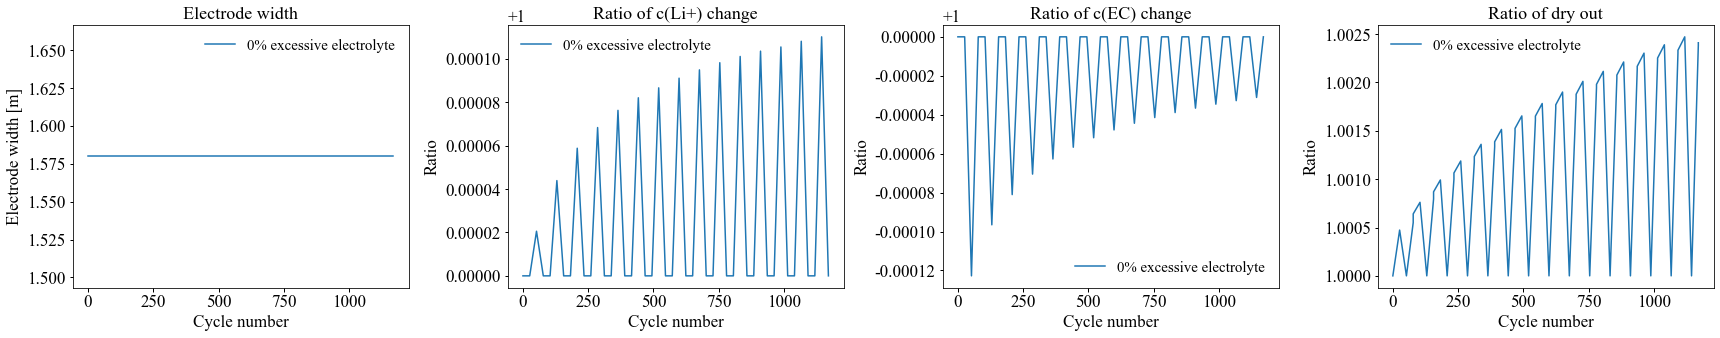

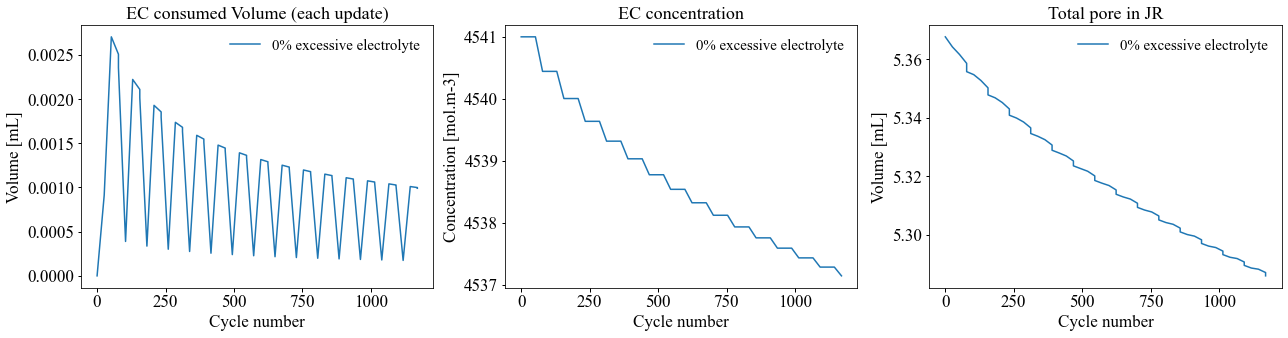

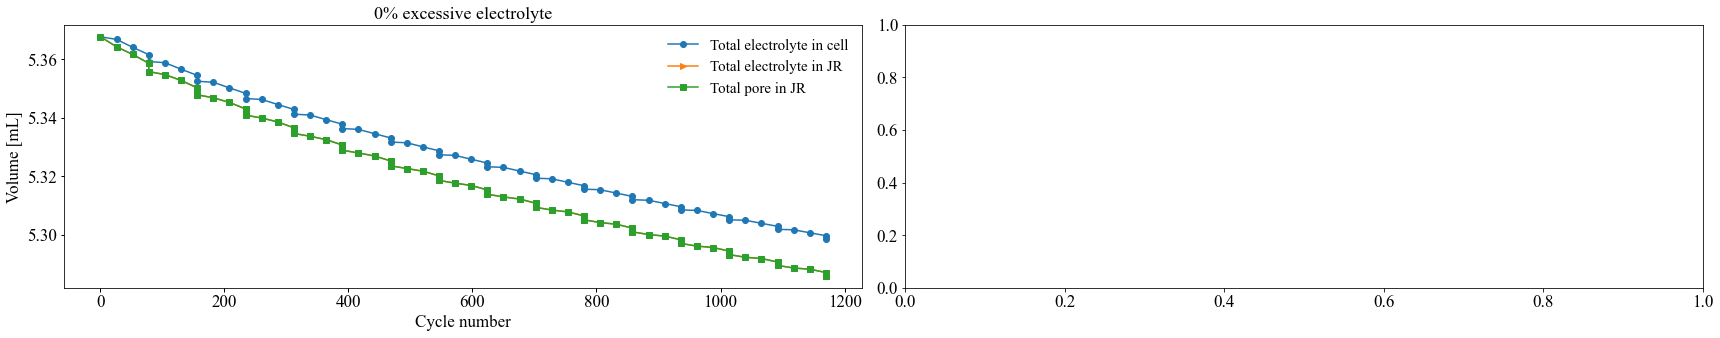

In [10]:
# Fig. 3 decsripiton of electrolyte dry-out
for mm in range(0,1):
    CeEC_All_All = [];
    for m in range(0,np.size(Ratio_excess_succeed)):
        CeEC_All =np.full(np.size(Ratio_CeEC_All_All[m]),Bulk_Sol_Con); 
        for i in range(1,np.size(Ratio_CeEC_All_All[m])):
            for k in range(0,i):
                CeEC_All[i] *= Ratio_CeEC_All_All[m][k];
        CeEC_All_All.append(CeEC_All);
    """ Vol_Elely_Tot_All_All.append(Vol_Elely_Tot_All) ;      Vol_Elely_JR_All_All.append(Vol_Elely_JR_All);          Vol_Pore_tot_All_All.append(Vol_Pore_tot_All);
    Ratio_CeEC_All_All.append(Ratio_CeEC_All);             Ratio_CeLi_All_All.append(Ratio_CeLi_All);              Ratio_Dryout_All_All.append(Ratio_Dryout_All);
    Vol_EC_consumed_All_All.append(Vol_EC_consumed_All);   Vol_Elely_need_All_All.append(Vol_Elely_need_All);      Width_all_All.append(Width_all);
    Vol_Elely_add_All_All.append(Vol_Elely_add_All);       Vol_Pore_decrease_All_All.append(Vol_Pore_decrease_All); """
    # modify:
    """ Width_all_All_md =[]; Ratio_CeLi_All_All_md=[]; Ratio_CeEC_All_All_md =[]; Ratio_Dryout_All_All_md =[];
    for m in index2:
        Width_all_All_md.append(Width_all_All[m]);
        Ratio_CeLi_All_All_md.append(Ratio_CeLi_All_All[m]);
        Ratio_CeEC_All_All_md.append(Ratio_CeEC_All_All[m]);
        Ratio_Dryout_All_All_md.append(Ratio_Dryout_All_All[m]); """
    Num_subplot = 4;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles2, Width_all_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles2, Ratio_CeLi_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(cycles2, Ratio_CeEC_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[3].plot(cycles2, Ratio_Dryout_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Ratio",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_ylabel("Electrode width [m]",   fontdict={'family':'Times New Roman','size':fs})

    axs[0].set_title("Electrode width",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Ratio of c(Li+) change",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title("Ratio of c(EC) change",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[3].set_title("Ratio of dry out",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-3a Dry out extent vs cycle number.png", dpi=600)    
    # How much electrolyte is consumed? What is the EC concentration over time?
    Num_subplot = 3;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(18,4.8),tight_layout=True)
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles2, Vol_EC_consumed_All_All[i],   '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles2, CeEC_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(cycles2, Vol_Pore_tot_All_All[i],     '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    axs[0].set_ylabel("Volume [mL]",   fontdict={'family':'Times New Roman','size':fs})
    axs[1].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
    axs[2].set_ylabel("Volume [mL]",   fontdict={'family':'Times New Roman','size':fs})


    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels] ;del labels;
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("EC consumed Volume (each update)",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("EC concentration",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title("Total pore in JR",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-3b EC Volume and EC concentration vs cycle number.png", dpi=600)  

    Num_subplot = np.size(Ratio_excess_succeed);
    fig, axs = plt.subplots(1,2, figsize=(24 ,4.8),tight_layout=True)
    for i in range(0,Num_subplot):
        axs[i].plot(cycles2, Vol_Elely_Tot_All_All[i],     '-o', label="Total electrolyte in cell" )
        axs[i].plot(cycles2, Vol_Elely_JR_All_All [i],     '->', label="Total electrolyte in JR" )
        axs[i].plot(cycles2, Vol_Pore_tot_All_All [i],     '-s', label="Total pore in JR" )
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Volume [mL]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
        axs[i].set_title('%.2g' % Ratio_plot[i] + f"% excessive electrolyte",   fontdict={'family':'Times New Roman','size':fs+1})

    #plt.savefig(BasicPath + Target+"/Fig-3c Volume of electrolyte and pore vs cycle number.png", dpi=600)    


In [33]:
0.105*0.105/8*1e18/60/60/24/365/100

437000.5707762556

In [ ]:
# Fig-S2 SOC at start of discharge
for mm in range(0,1):
    Num_subplot = 4; fs =17;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    axs[0].plot(cycles3, NegSoc_S_Dis_NonDry_All[0],   '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(cycles3, NegSoc_E_Dis_NonDry_All[0] ,  '-o', label='w/o dry-out model')  
    axs[2].plot(cycles3, PosSoc_S_Dis_NonDry_All[0],   '-o', label='w/o dry-out model')  
    axs[3].plot(cycles3, PosSoc_E_Dis_NonDry_All[0],   '-o', label='w/o dry-out model')  
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(cycles3, NegSoc_S_Dis_Dry_All_All[i], '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(cycles3, NegSoc_E_Dis_Dry_All_All[i] ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(cycles3, PosSoc_S_Dis_Dry_All_All[i], '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[3].plot(cycles3, PosSoc_E_Dis_Dry_All_All[i], '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle number",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Electrode SOC",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("Neg SOC at start of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Neg SOC at end of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title("Pos SOC at start of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[3].set_title("Pos SOC at end of discharge",   fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"/Fig-S2 Electrode SOC vs cycle number.png", dpi=600)

print(np.size(index))
print(np.size(cycles))
print(np.size(Epsilon_SEI_Neg_CCend_NonDry_All))
print( Epsilon_SEI_Neg_CCend_NonDry_All[10])

In [ ]:
# effect on current density  Fig-4 j_Neg_CCend_NonDry_All  Neg interfacial i_SEI  Negative electrode current density [A.m-2]
for mm in range(0,1):
    # compare first and last cycle in one subplot:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    Min_plt_Dry    = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All) 
    Max_plt_Dry    = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All)
    Min_plt_NonDry = min(min(c_s_i)   for c_s_i in j_Neg_CCend_NonDry_All) 
    Max_plt_NonDry = max(max(c_s_i)   for c_s_i in j_Neg_CCend_NonDry_All)
    Min_plt = min(Min_plt_Dry,Min_plt_NonDry); Max_plt = max(Max_plt_Dry,Max_plt_NonDry)
    axs[0].plot(x_n/np.max(x_n), j_Neg_CCend_NonDry_All[0][:-1], '-o', label="Non Dry out" ) # first cycle
    axs[1].plot(x_n/np.max(x_n), j_Neg_CCend_NonDry_All[-1][:-1], '-o',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x_n/np.max(x_n), j_Neg_CCend_Dry_All_All[i][0][:-1],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x_n/np.max(x_n), j_Neg_CCend_Dry_All_All[i][-1][:-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg electrode current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        axs[i].set_ylim(Min_plt-1,Max_plt) 
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-4a Neg electrode current density end of charge - compare different excessive electrolyte.png", dpi=600) 
    # compare Neg interfacial i_SEI:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    Min_plt_Dry    = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All) 
    Max_plt_Dry    = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All)
    Min_plt_NonDry = min(min(c_s_i)   for c_s_i in jSEI_Neg_Int_CCend_NonDry_All) 
    Max_plt_NonDry = max(max(c_s_i)   for c_s_i in jSEI_Neg_Int_CCend_NonDry_All)
    Min_plt = min(Min_plt_Dry,Min_plt_NonDry); Max_plt = max(Max_plt_Dry,Max_plt_NonDry)
    axs[0].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_NonDry_All[0], '-', label="Non Dry out" ) # first cycle
    axs[1].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_NonDry_All[-1], '-',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_Dry_All_All[i][0],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg SEI inter current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        axs[i].set_ylim(Min_plt*1.1,Max_plt*0.8)
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-4b Neg interfacial i_SEI end of charge - compare different excessive electrolyte.png", dpi=600) 



In [ ]:
print(Epsilon_CCend_Dry_All_All[2][0])
print(Epsilon_CCend_Dry_All_All[2][-1])

In [ ]:
# Fig-5a,b First and Last ageing cycle CC end c(Li+), Porosity and Porosity times electrolyte -
#  things to do: merge the tewo figures together by assigning color
for mm in range(0,1):
    Num_subplot = 3; 
    fig, axs = plt.subplots(1,Num_subplot, figsize=(21,5),tight_layout=True)
    axs[1].plot(x/np.max(x), Epsilon_CCend_NonDry_All[0], '-', label="Non Dry out" ) 
    axs[2].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[0], '-',label="Non Dry out" )
    axs[0].plot(x/np.max(x), c_Li_Elely_CCend_NonDry_All[0], '-',label="Non Dry out" )
    # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[-1]/Epsilon_CCend_NonDry_All[0], '-',label="Non Dry out" )
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[1].plot(x/np.max(x), Epsilon_CCend_Dry_All_All[i][0],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) 
        axs[0].plot(x/np.max(x), c_Li_Elely_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][-1] / Epsilon_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    axs[1].set_ylabel("Porosity",   fontdict={'family':'Times New Roman','size':fs})
    axs[2].set_ylabel("Porosity times electrolyte",   fontdict={'family':'Times New Roman','size':fs})
    axs[0].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
    #axs[0].set_ylim(300,4800);axs[1].set_ylim(0.05,0.48);axs[2].set_ylim(0.04,0.7);
    for i in range(0,Num_subplot):    
        axs[i].set_xlim(-0.05,1.05);
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[1].set_title(f"Porosity", fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title(f"Porosity times electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    axs[0].set_title(f"Li+ concentration in electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-5a First ageing cycle CC end c(Li+), Porosity and Porosity times electrolyte.png", dpi=600) 

    Num_subplot = 3; 
    fig, axs = plt.subplots(1,Num_subplot, figsize=(21,5),tight_layout=True)
    axs[1].plot(x/np.max(x), Epsilon_CCend_NonDry_All[-1], '-', label="Non Dry out" ) 
    axs[2].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[-1], '-',label="Non Dry out" )
    axs[0].plot(x/np.max(x), c_Li_Elely_CCend_NonDry_All[-1], '-',label="Non Dry out" )
    # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_NonDry_All[-1]/Epsilon_CCend_NonDry_All[-1], '-',label="Non Dry out" )
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[1].plot(x/np.max(x), Epsilon_CCend_Dry_All_All[i][-1],  '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[2].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) 
        axs[0].plot(x/np.max(x), c_Li_Elely_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        # axs[3].plot(x/np.max(x), Epsilon_ce_CCend_Dry_All_All[i][-1] / Epsilon_CCend_Dry_All_All[i][-1], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    axs[1].set_ylabel("Porosity",   fontdict={'family':'Times New Roman','size':fs})
    axs[2].set_ylabel("Porosity times electrolyte",   fontdict={'family':'Times New Roman','size':fs})
    axs[0].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
    #axs[0].set_ylim(10,2000);axs[1].set_ylim(0.01,0.48);axs[2].set_ylim(0.001,0.9);
    for i in range(0,Num_subplot): 
        axs[i].set_xlim(-0.05,1.05);   
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[1].set_title(f"Porosity", fontdict={'family':'Times New Roman','size':fs+1})
    axs[2].set_title(f"Porosity times electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    axs[0].set_title(f"Li+ concentration in electrolyte", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-5b Last ageing cycle CC end c(Li+), Porosity and Porosity times electrolyte.png", dpi=600) 

In [ ]:
# Fig-6a,b  effectvie ElelyConduct_CCend_NonDry_All and Effective ElelyDiff_CCend_NonDry_All 
for mm in range(0,1):
    # compare first and last cycle in one subplot:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    axs[0].plot(x/np.max(x), Eff_ElelyDiff_CCend_NonDry_All[0],'-', label="Non Dry out" ) # first cycle
    axs[1].plot(x/np.max(x), Eff_ElelyDiff_CCend_NonDry_All[-1], '-',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x/np.max(x), Eff_ElelyDiff_CCend_Dry_All_All[i][0],   '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x/np.max(x), Eff_ElelyDiff_CCend_Dry_All_All[i][-1],'-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte diffusivity [m2.s-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-6d Effective Electrolyte diffusivity- compare different excessive electrolyte.png", dpi=600) 

    # compare first and last cycle in one subplot:
    Num_subplot = 2; 
    fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
    axs[0].plot(x/np.max(x), Eff_ElelyConduct_CCend_NonDry_All[0] ,'-', label="Non Dry out" ) # first cycle
    axs[1].plot(x/np.max(x), Eff_ElelyConduct_CCend_NonDry_All[-1],'-',label="Non Dry out" ) # last cycle
    for i in range(0,np.size(Ratio_excess_succeed)): 
        axs[0].plot(x/np.max(x), Eff_ElelyConduct_CCend_Dry_All_All[i][0], '-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # first cycle
        axs[1].plot(x/np.max(x), Eff_ElelyConduct_CCend_Dry_All_All[i][-1],'-', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" ) # last cycle
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte conductivity [S.m-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        
    axs[0].set_title(f"First Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title(f"Last Ageing cycle", fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-6b Effective Electrolyte conductivity- compare different excessive electrolyte.png", dpi=600) 

In [ ]:
# Fig-S3-a,b Li+ concentration in electrolyte;Effective Electrolyte conductivity;Effective Electrolyte diffusivity- compare different cycles
for mm in range(0,1):
    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    Min_plt = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in c_Li_Elely_CCend_Dry_All_All) 
    Max_plt = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in c_Li_Elely_CCend_Dry_All_All) 
    # compare different x/np.max(x) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x/np.max(x), c_Li_Elely_CCend_NonDry_All[i],     '-', label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x/np.max(x), c_Li_Elely_CCend_Dry_All_All[k-1][i], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Li+ concentration in electrolyte [mol.m-3]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # # axs[i].legend(prop={'family':'Times New Roman','size':fs-5},loc='best',frameon=False)  
        axs[i].set_ylim(Min_plt-0.5e3,Max_plt+0.5e3)
    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S3a Li+ concentration in electrolyte- compare different cycles.png", dpi=600)

    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    # compare different x/np.max(x) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x/np.max(x), Eff_ElelyConduct_CCend_NonDry_All[i] ,     '-', label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x/np.max(x), Eff_ElelyConduct_CCend_Dry_All_All[k-1][i] , '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte conductivity [S.m-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-5},loc='best',frameon=False)  
    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S3b Effective Electrolyte conductivity- compare different cycles.png", dpi=600)

    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    # compare different x/np.max(x) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x/np.max(x), Eff_ElelyDiff_CCend_NonDry_All[i],  '-', label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x/np.max(x), Eff_ElelyDiff_CCend_Dry_All_All[k-1][i], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Cell thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Effective electrolyte diffusivity [m2.s-1]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S3c Effective Electrolyte diffusivity- compare different cycles.png", dpi=600)


In [ ]:
# Fig-S4   Neg electrode current density end of charge;Neg interfacial i_SEI- compare different cycles
for mm in range(0,1):
    x_n_s = x_n[:-2];
    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1; 
    Min_plt = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All) 
    Max_plt = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in j_Neg_CCend_Dry_All_All) 
    # compare different x_n/np.max(x_n) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x_n/np.max(x_n), j_Neg_CCend_NonDry_All[i][:-1],    '-',label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x_n/np.max(x_n), j_Neg_CCend_Dry_All_All[k-1][i][:-1], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg electrode current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        #axs[i].set_ylim(Min_plt-2,Max_plt)

    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S4a Neg electrode current density end of charge - compare different cycles.png", dpi=600)


    fs = 17;  lw = 2; cm = 1/2.4; 
    Num_subplot = np.size(Ratio_plot)+1;  
    Min_plt = min(min(   min(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All) 
    Max_plt = max(max(   max(c_s_i_i) for  c_s_i_i in c_s_i     ) for c_s_i in jSEI_Neg_Int_CCend_Dry_All_All)
    # compare different x_n/np.max(x_n) in one subplot:
    fig, axs = plt.subplots(1,Num_subplot, figsize=(24,4.8),tight_layout=True)
    for i in range(0,np.size(index2)): 
        axs[0].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_NonDry_All[i],    '-',label=f'Cycle {cycles[i]}')
        for k in range(1,Num_subplot):
            axs[k].plot(x_n/np.max(x_n), jSEI_Neg_Int_CCend_Dry_All_All[k-1][i], '-', label=f'Cycle {cycles[i]}')
    for i in range(0,Num_subplot):    
        axs[i].set_xlabel("Dimensionless Neg thickness",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Neg SEI inter current density [A.m-2]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        # axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        #axs[i].set_ylim(-1e-4,-2e-5)

    axs[0].set_title("For Non Dry out", fontdict={'family':'Times New Roman','size':fs+1})
    for k in range(1,Num_subplot):
        axs[k].set_title('%.2g' % Ratio_plot[k-1] + f"% excessive electrolyte" , fontdict={'family':'Times New Roman','size':fs+1})
    #plt.savefig(BasicPath + Target+"Fig-S4b Neg interfacial i_SEI- compare different cycles.png", dpi=600)


In [ ]:
# Save data:
# variables set:
mdic = {
    "Total_Cycles": Total_Cycles,
    "Cycle_bt_RPT": Cycle_bt_RPT,
    "Real_SaveAs_Cycles": Real_SaveAs_Cycles,
    "Small_Loop": Small_Loop,
    "SaveTimes": SaveTimes,
    "RPT_Cycles": RPT_Cycles,
    "Ratio_excess":        Ratio_excess,
    "Ratio_excess_succeed":        Ratio_excess_succeed,
    "Ratio_plot":        Ratio_plot,
    "index":        index,
    "index2":        index2,
    "cycles":        cycles,
    "cycles2":        cycles2,
    "cycles3":        cycles3,
    "CeEC_All_All":   CeEC_All_All,
    "NegSoc_S_Dis_NonDry_All": NegSoc_S_Dis_NonDry_All,
    "NegSoc_E_Dis_NonDry_All": NegSoc_E_Dis_NonDry_All,
    "PosSoc_S_Dis_NonDry_All": PosSoc_S_Dis_NonDry_All,
    "PosSoc_E_Dis_NonDry_All": PosSoc_E_Dis_NonDry_All,
    "NegSoc_S_Dis_Dry_All_All": NegSoc_S_Dis_Dry_All_All,
    "NegSoc_E_Dis_Dry_All_All": NegSoc_E_Dis_Dry_All_All,
    "PosSoc_S_Dis_Dry_All_All": PosSoc_S_Dis_Dry_All_All,
    "PosSoc_E_Dis_Dry_All_All": PosSoc_E_Dis_Dry_All_All,
    "Vol_Pore_JR_NonDry_All":Vol_Pore_JR_NonDry_All,
    "Vol_Elely_Tot_All_All":        Vol_Elely_Tot_All_All,
    "Vol_Elely_JR_All_All":        Vol_Elely_JR_All_All,
    "Vol_Pore_tot_All_All":        Vol_Pore_tot_All_All,
    "Ratio_CeEC_All_All":        Ratio_CeEC_All_All,
    "Ratio_CeLi_All_All":        Ratio_CeLi_All_All,
    "Ratio_Dryout_All_All":        Ratio_Dryout_All_All,
    "Vol_EC_consumed_All_All":        Vol_EC_consumed_All_All,
    "Vol_Elely_need_All_All":        Vol_Elely_need_All_All,
    "Width_all_All":        Width_all_All,
    "Vol_Elely_add_All_All":        Vol_Elely_add_All_All,
    "Vol_Pore_decrease_All_All":        Vol_Pore_decrease_All_All,
    "Tot_Li_JR_CCend_NonDry_All":Tot_Li_JR_CCend_NonDry_All,
    "Tot_Li_Elely_CCend_NonDry_All":Tot_Li_Elely_CCend_NonDry_All,
    "Tot_Li_Solid_CCend_NonDry_All":Tot_Li_Solid_CCend_NonDry_All,
    "Tot_LiLoss_Solid_CCend_NonDry_All":Tot_LiLoss_Solid_CCend_NonDry_All,
    "Tot_LiLoss_Elely_CCend_NonDry_All":Tot_LiLoss_Elely_CCend_NonDry_All,
    "Tot_Li_JR_CCend_Dry_All_All":Tot_Li_JR_CCend_Dry_All_All,
    "Tot_Li_Elely_CCend_Dry_All_All":Tot_Li_Elely_CCend_Dry_All_All,
    "Tot_Li_Solid_CCend_Dry_All_All":Tot_Li_Solid_CCend_Dry_All_All,
    "Tot_LiLoss_Solid_CCend_Dry_All_All":Tot_LiLoss_Solid_CCend_Dry_All_All,
    "Tot_LiLoss_Elely_CCend_Dry_All_All":Tot_LiLoss_Elely_CCend_Dry_All_All,

    "Total_Cycles_NonDry": Total_Cycles_NonDry,
    "SaveTimes_NonDry": SaveTimes_NonDry,
    "index_NonDry":        index_NonDry,
    "index2_NonDry":        index2_NonDry,
    "cycles_NonDry":        cycles_NonDry,
    "cycles3_NonDry":        cycles3_NonDry,  

    "Index_update_all_all":        Index_update_all_all,
    "cs_Neg_Max":    cs_Neg_Max,

    "CeEC_0":        CeEC_0,
    "CeLi_0":        CeLi_0,
    "T_0":        T_0,
    "Cap_RPT_NonDry_All":  Cap_RPT_NonDry_All,  #  
    "Charge_ThroughPut_NonDry_All":  Charge_ThroughPut_NonDry_All,
    "CapLoss_LiP_NonDry_All": CapLoss_LiP_NonDry_All,
    "molLoss_SEI_NonDry_All":molLoss_SEI_NonDry_All,
    "Cap_Pos_NonDry_All":     Cap_Pos_NonDry_All,
    "Cap_Neg_NonDry_All":     Cap_Neg_NonDry_All,
    "R_Local_ECM_NonDry_All": R_Local_ECM_NonDry_All,
    "R_Neg_X_avg_NonDry_All": R_Neg_X_avg_NonDry_All,
    "Time_RPT_CDend_NonDry_All":        Time_RPT_CDend_NonDry_All,
    "Vol_RPT_CDend_NonDry_All":         Vol_RPT_CDend_NonDry_All,

    "Cap_RPT_Dry_All_All":  Cap_RPT_Dry_All_All,
    "Charge_ThroughPut_Dry_All_All":  Charge_ThroughPut_Dry_All_All,
    "CapLoss_LiP_Dry_All_All": CapLoss_LiP_Dry_All_All,
    "molLoss_SEI_Dry_All_All":  molLoss_SEI_Dry_All_All,
    "Cap_Neg_Dry_All_All":     Cap_Neg_Dry_All_All,
    "Cap_Pos_Dry_All_All":     Cap_Pos_Dry_All_All,
    "R_Local_ECM_Dry_All_All": R_Local_ECM_Dry_All_All,
    "R_Neg_X_avg_Dry_All_All": R_Neg_X_avg_Dry_All_All,  
    "Time_RPT_CDend_Dry_All_All":         Time_RPT_CDend_Dry_All_All,
    "Vol_RPT_CDend_Dry_All_All":          Vol_RPT_CDend_Dry_All_All,

    "x_n":        x_n,
    "x":        x,
    # CC end ageing cycle
    "Epsilon_Neg_CCend_NonDry_All":       Epsilon_Neg_CCend_NonDry_All,
    "Epsilon_SEI_Neg_CCend_NonDry_All":   Epsilon_SEI_Neg_CCend_NonDry_All,
    "Epsilon_CCend_NonDry_All":           Epsilon_CCend_NonDry_All,
    "Epsilon_ce_CCend_NonDry_All":        Epsilon_ce_CCend_NonDry_All,
    "jSEI_Neg_Int_CCend_NonDry_All":      jSEI_Neg_Int_CCend_NonDry_All,
    "j_Neg_Int_CCend_NonDry_All":         j_Neg_Int_CCend_NonDry_All,
    "j_Neg_CCend_NonDry_All":             j_Neg_CCend_NonDry_All,
    "Eta_Elely_CCend_NonDry_All":     Eta_Elely_CCend_NonDry_All,
    "c_Li_Elely_CCend_NonDry_All":        c_Li_Elely_CCend_NonDry_All,
    "Eta_Neg_rec_CCend_NonDry_All":       Eta_Neg_rec_CCend_NonDry_All,
    "c_s_Neg_Surf_CCend_NonDry_All":      c_s_Neg_Surf_CCend_NonDry_All,
    "ElelyConduct_CCend_NonDry_All":      ElelyConduct_CCend_NonDry_All,
    "ElelyDiff_CCend_NonDry_All":         ElelyDiff_CCend_NonDry_All,
    "Eff_ElelyConduct_CCend_NonDry_All":  Eff_ElelyConduct_CCend_NonDry_All,
    "Eff_ElelyDiff_CCend_NonDry_All":     Eff_ElelyDiff_CCend_NonDry_All,
    # CD end ageing cycle
    "Epsilon_Neg_CDend_NonDry_All":       Epsilon_Neg_CDend_NonDry_All,
    "Epsilon_SEI_Neg_CDend_NonDry_All":   Epsilon_SEI_Neg_CDend_NonDry_All,
    "Epsilon_CDend_NonDry_All":           Epsilon_CDend_NonDry_All,
    "Epsilon_ce_CDend_NonDry_All":        Epsilon_ce_CDend_NonDry_All,
    "jSEI_Neg_Int_CDend_NonDry_All":      jSEI_Neg_Int_CDend_NonDry_All,
    "j_Neg_Int_CDend_NonDry_All":         j_Neg_Int_CDend_NonDry_All,
    "j_Neg_CDend_NonDry_All":             j_Neg_CDend_NonDry_All,
    "Eta_Elely_CDend_NonDry_All":     Eta_Elely_CDend_NonDry_All,
    "c_Li_Elely_CDend_NonDry_All":        c_Li_Elely_CDend_NonDry_All,
    "Eta_Neg_rec_CDend_NonDry_All":       Eta_Neg_rec_CDend_NonDry_All,
    "c_s_Neg_Surf_CDend_NonDry_All":      c_s_Neg_Surf_CDend_NonDry_All,
    "ElelyConduct_CDend_NonDry_All":      ElelyConduct_CDend_NonDry_All,
    "ElelyDiff_CDend_NonDry_All":         ElelyDiff_CDend_NonDry_All,
    "Eff_ElelyConduct_CDend_NonDry_All":  Eff_ElelyConduct_CDend_NonDry_All,
    "Eff_ElelyDiff_CDend_NonDry_All":     Eff_ElelyDiff_CDend_NonDry_All,


    # CC end ageing cycle
    "Epsilon_Neg_CCend_Dry_All_All"    :  Epsilon_Neg_CCend_Dry_All_All,
    "Epsilon_SEI_Neg_CCend_Dry_All_All":  Epsilon_SEI_Neg_CCend_Dry_All_All,
    "Epsilon_CCend_Dry_All_All":          Epsilon_CCend_Dry_All_All,
    "Epsilon_ce_CCend_Dry_All_All":       Epsilon_ce_CCend_Dry_All_All,
    "jSEI_Neg_Int_CCend_Dry_All_All":     jSEI_Neg_Int_CCend_Dry_All_All,
    "j_Neg_Int_CCend_Dry_All_All":        j_Neg_Int_CCend_Dry_All_All,
    "j_Neg_CCend_Dry_All_All":            j_Neg_CCend_Dry_All_All,
    "Eta_Elely_CCend_Dry_All_All":    Eta_Elely_CCend_Dry_All_All,
    "c_Li_Elely_CCend_Dry_All_All":       c_Li_Elely_CCend_Dry_All_All,
    "Eta_Neg_rec_CCend_Dry_All_All":      Eta_Neg_rec_CCend_Dry_All_All,
    "c_s_Neg_Surf_CCend_Dry_All_All":     c_s_Neg_Surf_CCend_Dry_All_All,
    "ElelyConduct_CCend_Dry_All_All":     ElelyConduct_CCend_Dry_All_All,
    "ElelyDiff_CCend_Dry_All_All":        ElelyDiff_CCend_Dry_All_All,
    "Eff_ElelyConduct_CCend_Dry_All_All": Eff_ElelyConduct_CCend_Dry_All_All,
    "Eff_ElelyDiff_CCend_Dry_All_All":    Eff_ElelyDiff_CCend_Dry_All_All,
    # CD end ageing cycle
    "Epsilon_Neg_CDend_Dry_All_All"    :  Epsilon_Neg_CDend_Dry_All_All,
    "Epsilon_SEI_Neg_CDend_Dry_All_All":  Epsilon_SEI_Neg_CDend_Dry_All_All,
    "Epsilon_CDend_Dry_All_All":          Epsilon_CDend_Dry_All_All,
    "Epsilon_ce_CDend_Dry_All_All":       Epsilon_ce_CDend_Dry_All_All,
    "jSEI_Neg_Int_CDend_Dry_All_All":     jSEI_Neg_Int_CDend_Dry_All_All,
    "j_Neg_Int_CDend_Dry_All_All":        j_Neg_Int_CDend_Dry_All_All,
    "j_Neg_CDend_Dry_All_All":            j_Neg_CDend_Dry_All_All,
    "Eta_Elely_CDend_Dry_All_All":    Eta_Elely_CDend_Dry_All_All,
    "c_Li_Elely_CDend_Dry_All_All":       c_Li_Elely_CDend_Dry_All_All,
    "Eta_Neg_rec_CDend_Dry_All_All":      Eta_Neg_rec_CDend_Dry_All_All,
    "c_s_Neg_Surf_CDend_Dry_All_All":     c_s_Neg_Surf_CDend_Dry_All_All,
    "ElelyConduct_CDend_Dry_All_All":     ElelyConduct_CDend_Dry_All_All,
    "ElelyDiff_CDend_Dry_All_All":        ElelyDiff_CDend_Dry_All_All,
    "Eff_ElelyConduct_CDend_Dry_All_All": Eff_ElelyConduct_CDend_Dry_All_All,
    "Eff_ElelyDiff_CDend_Dry_All_All":    Eff_ElelyDiff_CDend_Dry_All_All,

}
#savemat(BasicPath + Target+'StructDara_for_Mat.mat',mdic)

In [ ]:
# Print the chosen parameter set
format_str = '{:<75} {:>20}' 
print(format_str.format('PARAMETER', 'VALUE')) 
print("-"*97) 
fo = open(BasicPath + Target + "Parameter Used.txt","a+" );
for key, value in Para_0.items(): 
     try: 
            print(format_str.format(key, value)) 
            fo.write(format_str.format(key, value) + "\n");
     except TypeError: 
            print(format_str.format(key, value.__str__()))

In [ ]:
Model_0.variables.search('Total lithium')

In [ ]:
# X-averaged negative electrode open circuit potential [V];
# X-averaged positive electrode open circuit potential [V]
# Terminal voltage [V]
